In [1]:
%matplotlib inline
#!nrnivmodl mods # compile NEURON mod files if not already compiled
from __future__ import division
import numpy as np
from neuron import h, gui
import matplotlib.pyplot as plt
plt.ion();

### Instantiate model

In [2]:
h.load_file("import3d.hoc")
h.nrn_load_dll("mods/nrnmech.dll")  # this needs to be added on Windows
# for some weird reason NEURON doesn't care about the OS
# and Windows uses the forward slash: '/' as well...
h.load_file("models/L5PCbiophys3.hoc")
h.load_file("models/L5PCtemplate.hoc")
morph_fname = "morphologies/cell1.asc"
L5PC = h.L5PCtemplate(morph_fname)

### Add synapses, recorders, and plot function

In [3]:
# NMDA synapse
NMDA_synapse = h.ProbAMPANMDA2_RATIO(0.5, sec=L5PC.soma[0])
NMDA_netstim = h.NetStim(0.5, sec=L5PC.soma[0])
NMDA_netcons = h.NetCon(NMDA_netstim, NMDA_synapse)
NMDA_synapse.tau_r_AMPA = 0.33
NMDA_synapse.tau_d_AMPA = 1
NMDA_synapse.e = 0
NMDA_synapse.mgVoltageCoeff = 0.08
NMDA_netstim.number = 1
NMDA_netstim.noise  = 0
NMDA_netstim.start  = 100
NMDA_netcons.weight[0]= 0.9
# GABA synapse
GABA_synapse = h.Exp2Syn(0.5, sec=L5PC.soma[0])
GABA_netstim = h.NetStim(0.5, sec=L5PC.soma[0])
GABA_netcon = h.NetCon(GABA_netstim, GABA_synapse)
GABA_synapse.tau1 = 1.8
GABA_synapse.tau2 = 5
GABA_synapse.e = -80
GABA_netstim.number = 1
GABA_netstim.noise  = 0
GABA_netcon.weight[0] = 0.4
# synapse location
loc_1 = L5PC.apic[60](0.5)
NMDA_synapse.loc(loc_1)
GABA_synapse.loc(loc_1)

0.5

In [4]:
# recording
t = h.Vector()
t.record(h._ref_t)
voltage_at_NMDA_location = h.Vector()
voltage_at_NMDA_location.record(loc_1._ref_v) # record voltage at synaptic location
voltages  = {}

In [5]:
def plot_results(t, voltages, delay_1, delay_2):
    """Plot voltage traces for 2 selected decays"""
    plt.figure(figsize=(8, 5))
    ax = plt.subplot(1, 2, 1)
    ax.plot(t, voltages[9e9], '--k')
    ax.plot(t, voltages[delay_1])
    ax.plot(100, 0, 'or')
    ax.plot(100 + delay_1, 0,'ob', alpha=0.5)
    ax.text(130, 0, r'$\Delta$t = %ims' % delay_1, color='blue')
    ax.set_xlim([95, 200])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel('Voltage (mV)')
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(t, voltages[9e9], '--k')
    ax2.plot(t, voltages[delay_2])
    ax2.plot(100, 0, 'or')
    ax2.plot(100+delay_2, 0, 'ob', alpha=0.5)
    ax2.text(130, 0, r'$\Delta$t = %ims' % delay_2, color='blue')
    ax2.set_xlim([95, 200])
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.get_yaxis().set_visible(False)
    plt.suptitle('Time (ms)', x=0.5, y=0.05)

### Run simulations for differenct delays, save and plot the results

In [6]:
# general settings
h.v_init = -80
h.tstop = 200

NMDA_netcons.weight[0]= 50
GABA_netcon.weight[0] = 0.009
delta_ts = [0, 5, 10, 20, 9e9]  # delays between the NMDA activation to GABA activation
for delta_t in delta_ts:
    GABA_netstim.start = NMDA_netstim.start + delta_t
    h.run()
    voltages[delta_t] = np.array(voltage_at_NMDA_location)

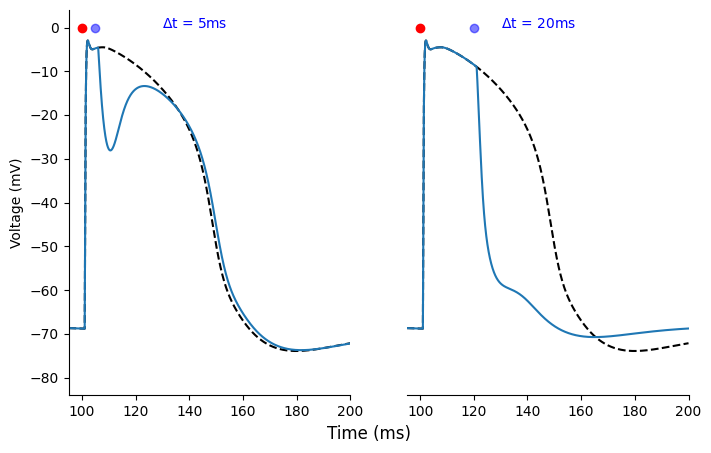

In [7]:
plot_results(t, voltages, 5, 20) # plot dealy 5 and delay 20